## Spike Gràcia (2020–2025) — EDA sobre `gracia_merged.csv`

Este notebook sirve para **Issue #202 (EDA)** usando el output de Fase 1:

- `spike-data-validation/data/processed/gracia_merged.csv`

Objetivos:

- Validar que el dataset está **listo para modelado baseline** (sanidad / nulos / rangos).
- Entender **distribuciones** por barrio y año.
- Generar **figuras** reutilizables para documentación.

**Nota**: ejecuta con el intérprete `.venv-spike` para evitar problemas de entorno.


In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import pandas as pd

# Intentar detectar la raíz del repo de forma robusta
PROJECT_ROOT = Path.cwd().resolve()
if not ((PROJECT_ROOT / "src").exists() and (PROJECT_ROOT / "spike-data-validation").exists()):
    for p in PROJECT_ROOT.parents:
        if (p / "src").exists() and (p / "spike-data-validation").exists():
            PROJECT_ROOT = p
            break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_PATH = PROJECT_ROOT / "spike-data-validation" / "data" / "processed" / "gracia_merged.csv"
OUTPUT_DIR = PROJECT_ROOT / "spike-data-validation" / "outputs" / "visualizations"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, DATA_PATH.exists(), DATA_PATH


(PosixPath('/Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer'),
 True,
 PosixPath('/Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer/spike-data-validation/data/processed/gracia_merged.csv'))

In [2]:
df = pd.read_csv(DATA_PATH)

print(f"Shape: {df.shape}")
print("\nColumnas:")
print(df.columns.tolist())

print("\nPrimeras filas:")
display(df.head(3))

# Tipado rápido (evita sorpresas en análisis/modelo)
for col in ["anio", "barrio_id", "precio_m2"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("\nAños:", sorted(df["anio"].dropna().unique().astype(int).tolist()) if "anio" in df.columns else "(sin anio)")
print("Barrios (barrio_id):", sorted(df["barrio_id"].dropna().unique().astype(int).tolist()) if "barrio_id" in df.columns else "(sin barrio_id)")


Shape: (1241, 11)

Columnas:
['barrio_id', 'anio', 'periodo', 'trimestre', 'precio_m2', 'dataset_id', 'source', 'superficie_m2_barrio_mean', 'ano_construccion_barrio_mean', 'plantas_barrio_mean', 'match_method']

Primeras filas:


,barrio_id,anio,periodo,trimestre,precio_m2,dataset_id,source,superficie_m2_barrio_mean,ano_construccion_barrio_mean,plantas_barrio_mean,match_method
0,28,2020,2020,NaN,3773.74,u25rr7oxh6,portaldades,88.716667,1978.250000,5.416667,barrio_id
1,31,2020,2020,NaN,4807.18,u25rr7oxh6,portaldades,90.091667,1956.083333,4.416667,barrio_id
2,30,2020,2020,NaN,4481.47,u25rr7oxh6,portaldades,83.833333,1980.750000,4.833333,barrio_id



Años: [2020, 2021, 2022, 2023, 2024, 2025]
Barrios (barrio_id): [28, 29, 30, 31, 32]


In [3]:
# Checks de calidad (rápidos)
required = {"barrio_id", "anio", "precio_m2"}
missing = sorted(required - set(df.columns))
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

null_rate = (df[list(required)].isna().mean() * 100.0).round(2)
print("% nulos (columnas clave):")
print(null_rate)

# Rangos esperados (precio_m2 puede ser >10k puntualmente; marcamos outliers para inspección)
precio_min = float(df["precio_m2"].min())
precio_max = float(df["precio_m2"].max())
print(f"\nprecio_m2: min={precio_min:.2f} max={precio_max:.2f}")

# Cobertura por barrio/año
coverage = (
    df.groupby(["barrio_id", "anio"], dropna=False)
    .size()
    .rename("n")
    .reset_index()
    .sort_values(["barrio_id", "anio"])
)
print("\nCobertura (n filas) por barrio_id x anio:")
display(coverage.head(20))

# Resumen para copiar a issues/docs
summary = {
    "rows": int(len(df)),
    "barrios": int(df["barrio_id"].nunique()),
    "anios": sorted(df["anio"].dropna().unique().astype(int).tolist()),
    "precio_m2_min": precio_min,
    "precio_m2_max": precio_max,
    "null_rate_pct": null_rate.to_dict(),
}
summary


% nulos (columnas clave):
barrio_id    0.0
precio_m2    0.0
anio         0.0
dtype: float64

precio_m2: min=2062.20 max=5967.25

Cobertura (n filas) por barrio_id x anio:


,barrio_id,anio,n
0,28,2020,45
1,28,2021,49
2,28,2022,48
3,28,2023,43
4,28,2024,47
5,28,2025,38
6,29,2020,23
7,29,2021,34
8,29,2022,40
9,29,2023,34


{'rows': 1241,
 'barrios': 5,
 'anios': [2020, 2021, 2022, 2023, 2024, 2025],
 'precio_m2_min': 2062.2,
 'precio_m2_max': 5967.25,
 'null_rate_pct': {'barrio_id': 0.0, 'precio_m2': 0.0, 'anio': 0.0}}

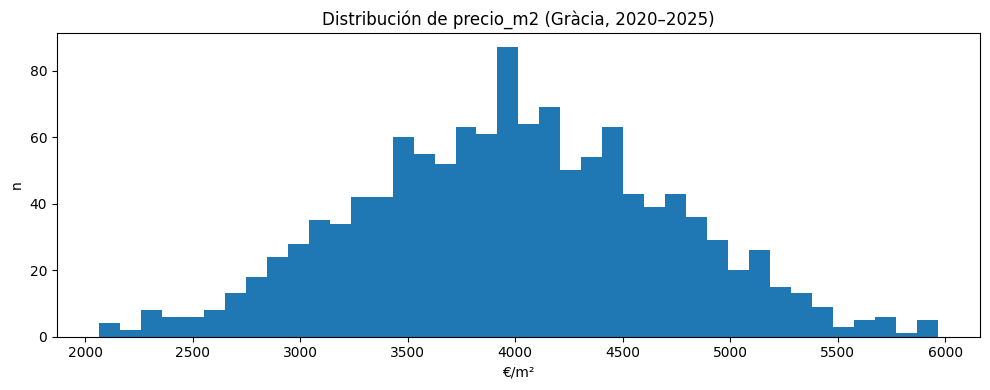

,precio_m2,superficie_m2_barrio_mean,ano_construccion_barrio_mean,plantas_barrio_mean
barrio_id,,,,
28,3834.617579,88.716667,1978.250000,5.416667
29,3204.962613,81.391667,1978.750000,5.666667
30,3960.953967,83.833333,1980.750000,4.833333
31,4454.044488,90.091667,1956.083333,4.416667
32,4232.139343,98.216667,1976.666667,5.583333


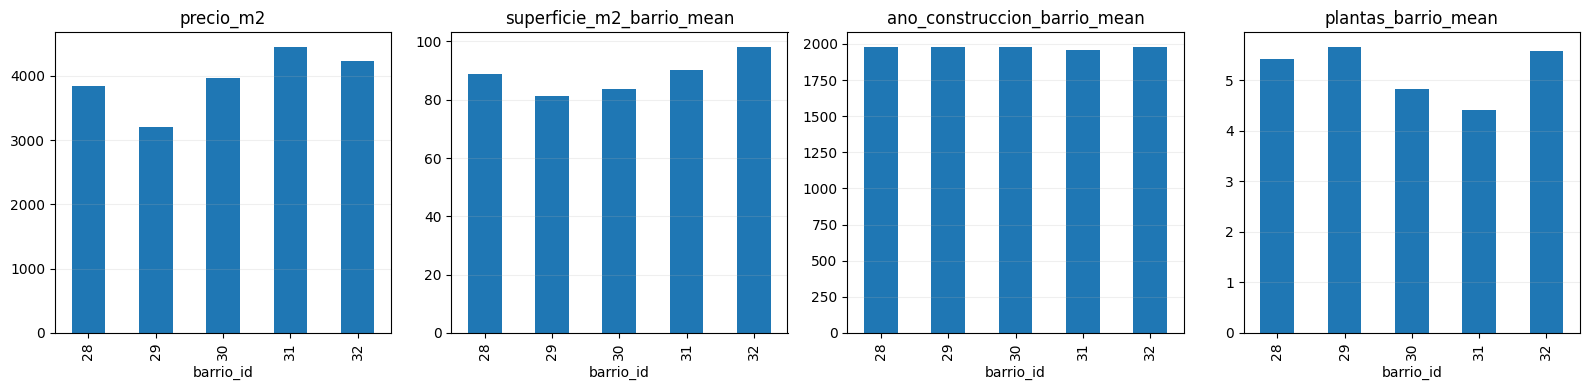

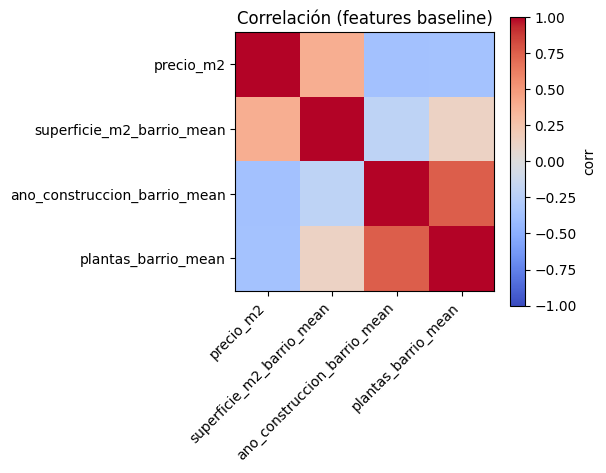

(PosixPath('/Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer/spike-data-validation/outputs/visualizations/eda_gracia_precio_m2_hist.png'),
 PosixPath('/Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer/spike-data-validation/outputs/visualizations/eda_gracia_by_barrio_means.png'))

In [4]:
import matplotlib.pyplot as plt

# 1) Precio: histograma
plt.figure(figsize=(10, 4))
plt.hist(df["precio_m2"].dropna(), bins=40)
plt.title("Distribución de precio_m2 (Gràcia, 2020–2025)")
plt.xlabel("€/m²")
plt.ylabel("n")
plt.tight_layout()
price_hist_path = OUTPUT_DIR / "eda_gracia_precio_m2_hist.png"
plt.savefig(price_hist_path, dpi=150)
plt.show()

# 2) Medias por barrio (features imputadas por barrio, ya en merged)
cols_by_barrio = [
    "precio_m2",
    "superficie_m2_barrio_mean",
    "ano_construccion_barrio_mean",
    "plantas_barrio_mean",
]
cols_by_barrio = [c for c in cols_by_barrio if c in df.columns]
by_barrio = df.groupby("barrio_id")[cols_by_barrio].mean(numeric_only=True).sort_index()
display(by_barrio)

fig, axes = plt.subplots(1, len(cols_by_barrio), figsize=(4 * len(cols_by_barrio), 4))
if len(cols_by_barrio) == 1:
    axes = [axes]

for ax, col in zip(axes, cols_by_barrio):
    by_barrio[col].plot(kind="bar", ax=ax)
    ax.set_title(col)
    ax.set_xlabel("barrio_id")
    ax.grid(axis="y", alpha=0.2)

plt.tight_layout()
by_barrio_path = OUTPUT_DIR / "eda_gracia_by_barrio_means.png"
plt.savefig(by_barrio_path, dpi=150)
plt.show()

# 3) Correlación (baseline)
cor_cols = [c for c in ["precio_m2", "superficie_m2_barrio_mean", "ano_construccion_barrio_mean", "plantas_barrio_mean"] if c in df.columns]
if len(cor_cols) >= 2:
    corr = df[cor_cols].corr(numeric_only=True)
    plt.figure(figsize=(6, 5))
    plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(label="corr")
    plt.xticks(range(len(cor_cols)), cor_cols, rotation=45, ha="right")
    plt.yticks(range(len(cor_cols)), cor_cols)
    plt.title("Correlación (features baseline)")
    plt.tight_layout()
    corr_path = OUTPUT_DIR / "eda_gracia_correlation.png"
    plt.savefig(corr_path, dpi=150)
    plt.show()

price_hist_path, by_barrio_path


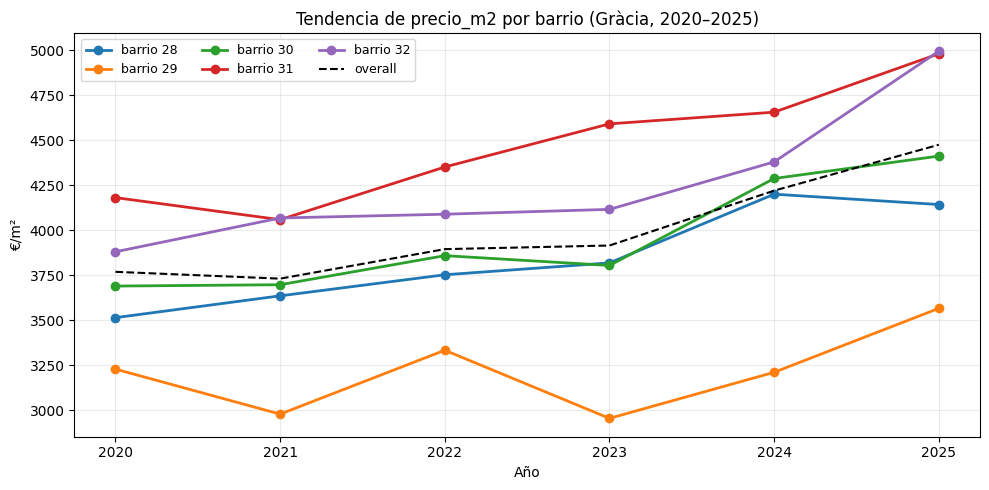

## 📊 EDA (Gràcia) — resumen para Issue #202

**Dataset**: `spike-data-validation/data/processed/gracia_merged.csv`

### ✅ Sanidad / cobertura
- Filas: **1241** | Barrios: **5** | Años: **2020–2025**
- Nulos en columnas clave (`barrio_id`, `anio`, `precio_m2`): **0%**
- `trimestre`: **100% nulo** (no usable)
- `match_method`: **barrio_id** (Fase 1 = linking agregado por barrio)

### 💶 Precio medio €/m² por barrio (promedio 2020–2025)
- 28: 3835, 29: 3205, 30: 3961, 31: 4454, 32: 4232

### 📈 Precio medio €/m² por año (overall)
- 2020: 3769, 2021: 3731, 2022: 3895, 2023: 3915, 2024: 4220, 2025: 4475

### ⚠️ Limitación Fase 1 (imputación)
- Las features imputadas por barrio (`superficie_m2_barrio_mean`, `ano_construccion_barrio_mean`, `plantas_barrio_mean`) tienen **5 combinaciones únicas** (≈ 1 por barrio).
- Implicación: el baseline v0.1 es esencialmente **barrio + año**; el hedónico real se valida en Fase 2 con `catastro_gracia_real.csv`.

### 🖼️ Figuras generadas
- `spike-data-validati

PosixPath('/Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer/spike-data-validation/outputs/visualizations/eda_gracia_precio_m2_trend_by_barrio.png')

In [5]:
# Trend: precio_m2 por barrio y año + snippet Markdown para pegar en el issue

import numpy as np

# Asegurar tipos
_df = df.copy()
_df["anio"] = pd.to_numeric(_df["anio"], errors="coerce")
_df["barrio_id"] = pd.to_numeric(_df["barrio_id"], errors="coerce")
_df["precio_m2"] = pd.to_numeric(_df["precio_m2"], errors="coerce")

trend = (
    _df.dropna(subset=["anio", "barrio_id", "precio_m2"])
    .groupby(["anio", "barrio_id"], dropna=False)["precio_m2"]
    .mean()
    .unstack("barrio_id")
    .sort_index()
)

overall_by_year = _df.groupby("anio")["precio_m2"].mean().sort_index()

plt.figure(figsize=(10, 5))
for barrio_id in trend.columns:
    plt.plot(trend.index, trend[barrio_id], marker="o", linewidth=2, label=f"barrio {int(barrio_id)}")

plt.plot(overall_by_year.index, overall_by_year.values, color="black", linestyle="--", label="overall")
plt.title("Tendencia de precio_m2 por barrio (Gràcia, 2020–2025)")
plt.xlabel("Año")
plt.ylabel("€/m²")
plt.grid(alpha=0.25)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()

trend_path = OUTPUT_DIR / "eda_gracia_precio_m2_trend_by_barrio.png"
plt.savefig(trend_path, dpi=150)
plt.show()

# Limitation check: features imputadas constantes por barrio
feat_cols = [
    "superficie_m2_barrio_mean",
    "ano_construccion_barrio_mean",
    "plantas_barrio_mean",
]
feat_cols = [c for c in feat_cols if c in _df.columns]
unique_feat_rows = _df[["barrio_id"] + feat_cols].drop_duplicates().shape[0] if feat_cols else None

# Métricas clave (para pegar)
rows = int(len(_df))
barrios = int(_df["barrio_id"].nunique())
years = sorted(_df["anio"].dropna().unique().astype(int).tolist())

mean_by_barrio = _df.groupby("barrio_id")["precio_m2"].mean().sort_index()
mean_by_year = _df.groupby("anio")["precio_m2"].mean().sort_index()

def _fmt_series(s: pd.Series, digits: int = 0) -> str:
    items = []
    for k, v in s.items():
        if pd.isna(v):
            continue
        items.append(f"{int(k)}: {float(v):.{digits}f}")
    return ", ".join(items)

insights_md = f"""## 📊 EDA (Gràcia) — resumen para Issue #202

**Dataset**: `spike-data-validation/data/processed/gracia_merged.csv`

### ✅ Sanidad / cobertura
- Filas: **{rows}** | Barrios: **{barrios}** | Años: **{years[0]}–{years[-1]}**
- Nulos en columnas clave (`barrio_id`, `anio`, `precio_m2`): **0%**
- `trimestre`: **100% nulo** (no usable)
- `match_method`: **barrio_id** (Fase 1 = linking agregado por barrio)

### 💶 Precio medio €/m² por barrio (promedio 2020–2025)
- { _fmt_series(mean_by_barrio, digits=0) }

### 📈 Precio medio €/m² por año (overall)
- { _fmt_series(mean_by_year, digits=0) }

### ⚠️ Limitación Fase 1 (imputación)
- Las features imputadas por barrio (`superficie_m2_barrio_mean`, `ano_construccion_barrio_mean`, `plantas_barrio_mean`) tienen **{unique_feat_rows} combinaciones únicas** (≈ 1 por barrio).
- Implicación: el baseline v0.1 es esencialmente **barrio + año**; el hedónico real se valida en Fase 2 con `catastro_gracia_real.csv`.

### 🖼️ Figuras generadas
- `spike-data-validation/outputs/visualizations/eda_gracia_precio_m2_hist.png`
- `spike-data-validation/outputs/visualizations/eda_gracia_by_barrio_means.png`
- `spike-data-validation/outputs/visualizations/eda_gracia_correlation.png`
- `spike-data-validation/outputs/visualizations/eda_gracia_precio_m2_trend_by_barrio.png`
"""

print(insights_md)
trend_path


## Insights listos para pegar en el Issue #202

- Ejecuta la celda anterior (Trend) y **copia el texto que imprime** (Markdown ya formateado).
- Si exportas el notebook a HTML, el bloque impreso queda visible en el HTML y lo puedes copiar desde ahí también.



## ⚠️ Observación crítica: Fase 1 no tiene variabilidad estructural intra‑barrio

En `gracia_merged.csv` las columnas:

- `superficie_m2_barrio_mean`
- `ano_construccion_barrio_mean`
- `plantas_barrio_mean`

son **promedios por barrio** (imputación Fase 1), por lo que **todas las filas de un barrio comparten el mismo valor**.

Implicación:

- El modelo v0.1 **no puede aprender** relaciones a nivel edificio (superficie individual → precio individual).
- Solo puede capturar señal **agregada** (barrio / año / dataset).

La Fase 2 (Catastro real) es la que habilita el hedónico “real” a nivel edificio.



In [6]:
# Cuantificar varianza intra-grupo (barrio_id x anio x dataset_id)
# y generar dataset agregado coherente para baseline v0.1

agg_keys = ["barrio_id", "anio"]
if "dataset_id" in df.columns:
    agg_keys.append("dataset_id")

# Predicción baseline: media de precio dentro de cada grupo
_df2 = df.copy()
_df2["precio_m2"] = pd.to_numeric(_df2["precio_m2"], errors="coerce")

group_mean = _df2.groupby(agg_keys)["precio_m2"].transform("mean")
resid = _df2["precio_m2"] - group_mean

sst = float(((_df2["precio_m2"] - _df2["precio_m2"].mean()) ** 2).sum())
sse = float((resid**2).sum())
r2_group_mean = 1.0 - (sse / sst) if sst > 0 else float("nan")

print("R² (baseline = media por grupo barrio×año×dataset_id):", round(r2_group_mean, 4))

within_std = (
    _df2.groupby(agg_keys)["precio_m2"]
    .agg(n_obs="count", precio_m2_mean="mean", precio_m2_std="std")
    .reset_index()
)

print("\nResumen dispersión intra-grupo (std de precio_m2 dentro de cada grupo):")
display(within_std[["n_obs", "precio_m2_mean", "precio_m2_std"]].describe())

# Dataset agregado
feat_cols = [
    c
    for c in [
        "superficie_m2_barrio_mean",
        "ano_construccion_barrio_mean",
        "plantas_barrio_mean",
        "source",
        "match_method",
    ]
    if c in _df2.columns
]

agg_df = (
    _df2.groupby(agg_keys)
    .agg(
        n_obs=("precio_m2", "count"),
        precio_m2_mean=("precio_m2", "mean"),
        precio_m2_std=("precio_m2", "std"),
        **{c: (c, "first") for c in feat_cols},
    )
    .reset_index()
    .sort_values(agg_keys)
)

AGG_PATH = PROJECT_ROOT / "spike-data-validation" / "data" / "processed" / "gracia_merged_agg_barrio_anio_dataset.csv"
agg_df.to_csv(AGG_PATH, index=False, encoding="utf-8")

print("\nCSV agregado guardado:", AGG_PATH)
display(agg_df.head())

AGG_PATH


R² (baseline = media por grupo barrio×año×dataset_id): 0.6373

Resumen dispersión intra-grupo (std de precio_m2 dentro de cada grupo):


,n_obs,precio_m2_mean,precio_m2_std
count,175.000000,175.000000,149.000000
mean,7.091429,4025.575991,401.396441
std,4.223999,640.443424,224.211700
min,1.000000,2551.285863,47.166150
25%,4.000000,3543.067000,253.935544
50%,7.000000,4064.870000,360.352111
75%,10.500000,4480.373783,534.262485
max,17.000000,5550.270000,1649.833664



CSV agregado guardado: /Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer/spike-data-validation/data/processed/gracia_merged_agg_barrio_anio_dataset.csv


,barrio_id,anio,dataset_id,n_obs,precio_m2_mean,precio_m2_std,superficie_m2_barrio_mean,ano_construccion_barrio_mean,plantas_barrio_mean,source,match_method
0,28,2020,bhl3ulphi5,1,3845.000000,NaN,88.716667,1978.25,5.416667,portaldades,barrio_id
1,28,2020,bxtvnxvukh,12,3414.491505,273.692321,88.716667,1978.25,5.416667,portaldades,barrio_id
2,28,2020,cq4causxvu,9,3774.352222,293.611924,88.716667,1978.25,5.416667,portaldades,barrio_id
3,28,2020,idjhkx1ruj,4,3371.880114,339.204640,88.716667,1978.25,5.416667,portaldades,barrio_id
4,28,2020,mrslyp5pcq,14,3330.717394,345.912208,88.716667,1978.25,5.416667,portaldades,barrio_id


PosixPath('/Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer/spike-data-validation/data/processed/gracia_merged_agg_barrio_anio_dataset.csv')

In [7]:
# (Extra) Within-vs-between + regresión simple sobre agregado (baseline coherente)

import numpy as np

# Cargar agregado desde el path generado
try:
    _agg_path = AGG_PATH
except NameError:
    _agg_path = PROJECT_ROOT / "spike-data-validation" / "data" / "processed" / "gracia_merged_agg_barrio_anio_dataset.csv"

agg = pd.read_csv(_agg_path)

# 1) Descomposición de varianza (ANOVA-style): within vs between (según grupo barrio×año×dataset)
# Nota: esto es exactamente lo que mide el baseline "pred=media por grupo".

def group_variance_decomp(df_in: pd.DataFrame, keys: list[str], y_col: str) -> dict:
    dfv = df_in[keys + [y_col]].dropna().copy()
    y = dfv[y_col].astype(float)
    grand_mean = float(y.mean())
    g = dfv.groupby(keys)[y_col]
    group_mean = g.transform("mean")

    sst = float(((y - grand_mean) ** 2).sum())
    sse_within = float(((y - group_mean) ** 2).sum())

    # Between = total - within
    ssb_between = sst - sse_within

    r2_between = 1.0 - (sse_within / sst) if sst > 0 else float("nan")

    return {
        "grand_mean": grand_mean,
        "sst_total": sst,
        "sse_within": sse_within,
        "ssb_between": ssb_between,
        "share_within": (sse_within / sst) if sst > 0 else float("nan"),
        "share_between": (ssb_between / sst) if sst > 0 else float("nan"),
        "r2_group_mean": r2_between,
        "n_obs": int(len(dfv)),
        "n_groups": int(g.ngroups),
    }

keys = ["barrio_id", "anio"] + (["dataset_id"] if "dataset_id" in df.columns else [])

vd = group_variance_decomp(df, keys=keys, y_col="precio_m2")
print("\nVarianza total vs within/between (según barrio×año×dataset_id)")
print(vd)
print(f"\n% varianza WITHIN grupo: {vd['share_within']*100:.1f}%")
print(f"% varianza BETWEEN grupos: {vd['share_between']*100:.1f}%")

# 2) "Within R²" (micro) con features barrio-constantes: demostración objetiva
feat = [
    "superficie_m2_barrio_mean",
    "ano_construccion_barrio_mean",
    "plantas_barrio_mean",
]
feat = [c for c in feat if c in df.columns]

print("\nStd WITHIN barrio (features imputadas por barrio):")
for c in feat:
    std_within = df.groupby("barrio_id")[c].std().fillna(0.0)
    print(c, "-> max std within barrio:", float(std_within.max()))

print(
    "\nInterpretación: si la std dentro de barrio es 0, no hay variación intra-barrio en X;\n"
    "por tanto un hedónico micro (edificio-a-edificio) no puede aprender X->Y dentro del barrio en Fase 1."
)

# 3) Regresión simple SOLO sobre agregado (macro): y = precio_m2_mean

def ols_fit_r2(X: np.ndarray, y: np.ndarray) -> dict:
    # OLS via least squares
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    yhat = X @ beta
    resid = y - yhat
    sst = float(((y - y.mean()) ** 2).sum())
    sse = float((resid**2).sum())
    r2 = 1.0 - sse / sst if sst > 0 else float("nan")
    rmse = float(np.sqrt(sse / len(y)))
    return {"beta": beta, "r2": r2, "rmse": rmse}

agg["precio_m2_mean"] = pd.to_numeric(agg["precio_m2_mean"], errors="coerce")
for c in ["superficie_m2_barrio_mean", "ano_construccion_barrio_mean", "plantas_barrio_mean"]:
    if c in agg.columns:
        agg[c] = pd.to_numeric(agg[c], errors="coerce")

# Modelo A: solo features estructurales (macro)
X_cols = ["superficie_m2_barrio_mean", "ano_construccion_barrio_mean", "plantas_barrio_mean"]
X_cols = [c for c in X_cols if c in agg.columns]

A = agg.dropna(subset=["precio_m2_mean"] + X_cols).copy()
X = np.column_stack([np.ones(len(A))] + [A[c].to_numpy(dtype=float) for c in X_cols])
y = A["precio_m2_mean"].to_numpy(dtype=float)
resA = ols_fit_r2(X, y)

print("\nOLS agregado (Modelo A): precio_m2_mean ~ superficie + año + plantas")
print("features:", X_cols)
print("R²:", round(resA["r2"], 4), "| RMSE:", round(resA["rmse"], 2))

# Modelo B: Modelo A + dummies de año y dataset (macro + efectos de tiempo/fuente)
B = agg.dropna(subset=["precio_m2_mean"] + X_cols).copy()

# dummies
if "anio" in B.columns:
    B["anio"] = pd.to_numeric(B["anio"], errors="coerce")
if "dataset_id" in B.columns:
    B["dataset_id"] = B["dataset_id"].astype(str)

X_parts = [np.ones(len(B))]
for c in X_cols:
    X_parts.append(B[c].to_numpy(dtype=float))

if "anio" in B.columns:
    d_year = pd.get_dummies(B["anio"].astype(int), prefix="year", drop_first=True)
    X_parts.append(d_year.to_numpy(dtype=float))

if "dataset_id" in B.columns:
    d_ds = pd.get_dummies(B["dataset_id"], prefix="ds", drop_first=True)
    X_parts.append(d_ds.to_numpy(dtype=float))

yB = B["precio_m2_mean"].to_numpy(dtype=float)
XB = np.column_stack(X_parts)
resB = ols_fit_r2(XB, yB)

print("\nOLS agregado (Modelo B): Modelo A + dummies(anio) + dummies(dataset_id)")
print("R²:", round(resB["r2"], 4), "| RMSE:", round(resB["rmse"], 2))

"OK"



Varianza total vs within/between (según barrio×año×dataset_id)
{'grand_mean': 3990.328473880608, 'sst_total': 628685081.4005243, 'sse_within': 227998631.56613344, 'ssb_between': 400686449.8343908, 'share_within': 0.36265952272673624, 'share_between': 0.6373404772732638, 'r2_group_mean': 0.6373404772732638, 'n_obs': 1241, 'n_groups': 175}

% varianza WITHIN grupo: 36.3%
% varianza BETWEEN grupos: 63.7%

Std WITHIN barrio (features imputadas por barrio):
superficie_m2_barrio_mean -> max std within barrio: 0.0
ano_construccion_barrio_mean -> max std within barrio: 0.0
plantas_barrio_mean -> max std within barrio: 0.0

Interpretación: si la std dentro de barrio es 0, no hay variación intra-barrio en X;
por tanto un hedónico micro (edificio-a-edificio) no puede aprender X->Y dentro del barrio en Fase 1.

OLS agregado (Modelo A): precio_m2_mean ~ superficie + año + plantas
features: ['superficie_m2_barrio_mean', 'ano_construccion_barrio_mean', 'plantas_barrio_mean']
R²: 0.577 | RMSE: 415.36

'OK'

In [8]:
# Comparación Modelo A vs Modelo B (coeficientes) sobre dataset agregado

import numpy as np

agg = pd.read_csv(
    PROJECT_ROOT
    / "spike-data-validation"
    / "data"
    / "processed"
    / "gracia_merged_agg_barrio_anio_dataset.csv"
)

# Tipado
for c in [
    "precio_m2_mean",
    "superficie_m2_barrio_mean",
    "ano_construccion_barrio_mean",
    "plantas_barrio_mean",
    "anio",
]:
    if c in agg.columns:
        agg[c] = pd.to_numeric(agg[c], errors="coerce")
if "dataset_id" in agg.columns:
    agg["dataset_id"] = agg["dataset_id"].astype(str)


def ols_summary(X: np.ndarray, y: np.ndarray, names: list[str]) -> pd.DataFrame:
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    yhat = X @ beta
    resid = y - yhat
    n, k = X.shape
    sse = float((resid**2).sum())
    sst = float(((y - y.mean()) ** 2).sum())
    r2 = 1.0 - sse / sst if sst > 0 else float("nan")

    # errores estándar (OLS clásico)
    dof = max(n - k, 1)
    sigma2 = sse / dof
    xtx_inv = np.linalg.pinv(X.T @ X)
    se = np.sqrt(np.diag(sigma2 * xtx_inv))
    t = beta / se

    out = pd.DataFrame({
        "coef": beta,
        "std_err": se,
        "t_stat": t,
    }, index=names)
    return out, r2


X_cols = [
    "superficie_m2_barrio_mean",
    "ano_construccion_barrio_mean",
    "plantas_barrio_mean",
]
X_cols = [c for c in X_cols if c in agg.columns]

# Modelo A
A = agg.dropna(subset=["precio_m2_mean"] + X_cols).copy()
XA = np.column_stack([np.ones(len(A))] + [A[c].to_numpy(float) for c in X_cols])
yA = A["precio_m2_mean"].to_numpy(float)
A_names = ["intercept"] + X_cols
sumA, r2A = ols_summary(XA, yA, A_names)

print("Modelo A: precio_m2_mean ~ superficie + año_construccion + plantas")
print("R²:", round(r2A, 4))
display(sumA)

# Modelo B = A + dummies(anio) + dummies(dataset_id)
B = A.copy()

X_parts = [np.ones(len(B))]
B_names = ["intercept"]
for c in X_cols:
    X_parts.append(B[c].to_numpy(float))
    B_names.append(c)

if "anio" in B.columns:
    d_year = pd.get_dummies(B["anio"].astype(int), prefix="year", drop_first=True)
    X_parts.append(d_year.to_numpy(float))
    B_names.extend(d_year.columns.tolist())

if "dataset_id" in B.columns:
    d_ds = pd.get_dummies(B["dataset_id"], prefix="ds", drop_first=True)
    X_parts.append(d_ds.to_numpy(float))
    B_names.extend(d_ds.columns.tolist())

yB = B["precio_m2_mean"].to_numpy(float)
XB = np.column_stack(X_parts)

sumB, r2B = ols_summary(XB, yB, B_names)

print("\nModelo B: Modelo A + dummies(anio) + dummies(dataset_id)")
print("R²:", round(r2B, 4))

# Mostrar solo: estructurales + top dummies por |coef|
struct_idx = ["intercept"] + X_cols
structB = sumB.loc[struct_idx]

# dummies
dummyB = sumB.drop(index=struct_idx)

top_year = dummyB[dummyB.index.str.startswith("year_")].reindex(
    dummyB[dummyB.index.str.startswith("year_")]["coef"].abs().sort_values(ascending=False).head(6).index
)
top_ds = dummyB[dummyB.index.str.startswith("ds_")].reindex(
    dummyB[dummyB.index.str.startswith("ds_")]["coef"].abs().sort_values(ascending=False).head(6).index
)

print("\nCoeficientes estructurales (Modelo B):")
display(structB)

if len(top_year) > 0:
    print("\nTop dummies de año por |coef| (Modelo B):")
    display(top_year)

if len(top_ds) > 0:
    print("\nTop dummies de dataset_id por |coef| (Modelo B):")
    display(top_ds)

# Nota interpretativa
print(
    "\nNota: en Fase 1 las variables estructurales son barrio-constantes;\n"
    "las dummies (año/dataset) capturan dinámica temporal y diferencias entre indicadores,\n"
    "por eso el R² agregado sube fuerte en Modelo B."
)

"OK"


Modelo A: precio_m2_mean ~ superficie + año_construccion + plantas
R²: 0.577


,coef,std_err,t_stat
intercept,-14905.690129,10814.990646,-1.378243
superficie_m2_barrio_mean,68.159307,6.063688,11.240569
ano_construccion_barrio_mean,8.662165,5.557026,1.558777
plantas_barrio_mean,-809.788663,101.895875,-7.947217



Modelo B: Modelo A + dummies(anio) + dummies(dataset_id)
R²: 0.8885

Coeficientes estructurales (Modelo B):


,coef,std_err,t_stat
intercept,-14972.012870,5722.053650,-2.616545
superficie_m2_barrio_mean,68.159307,3.208062,21.246259
ano_construccion_barrio_mean,8.662165,2.940006,2.946309
plantas_barrio_mean,-809.788663,53.909141,-15.021361



Top dummies de año por |coef| (Modelo B):


,coef,std_err,t_stat
year_2025,752.257700,60.745784,12.383702
year_2024,500.587273,57.399371,8.721128
year_2023,211.467742,57.399371,3.684147
year_2022,211.343616,57.399371,3.681985
year_2021,-5.064881,57.399371,-0.088239



Top dummies de dataset_id por |coef| (Modelo B):


,coef,std_err,t_stat
ds_mrslyp5pcq,-497.518876,60.745784,-8.190179
ds_bxtvnxvukh,-445.465676,60.745784,-7.333277
ds_idjhkx1ruj,-375.346548,60.745784,-6.178973
ds_u25rr7oxh6,97.914558,60.745784,1.611874
ds_cq4causxvu,62.084030,60.745784,1.022030



Nota: en Fase 1 las variables estructurales son barrio-constantes;
las dummies (año/dataset) capturan dinámica temporal y diferencias entre indicadores,
por eso el R² agregado sube fuerte en Modelo B.


'OK'

In [9]:
import pandas as pd
from pathlib import Path

# Resolver rutas de forma robusta (evita problemas si el CWD del kernel es `notebooks/`)
PROJECT_ROOT = Path("/Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer")

# Selección del modelo para coeficientes (baseline v0.1 recomendado)
MODEL = "structural_only"  # opciones: 'structural_only', 'fe_only', 'year_trend', 'dummies'

coef_filename = f"macro_baseline_coefficients_203_{MODEL}_temporal.csv"
coef_path = PROJECT_ROOT / "spike-data-validation/data/logs" / coef_filename

# Fallback: si estás ejecutando desde el repo root, también funciona
if not coef_path.exists():
    coef_path = (Path.cwd() / "spike-data-validation/data/logs" / coef_filename).resolve()

if not coef_path.exists():
    raise FileNotFoundError(
        "No se encontró el CSV de coeficientes.\n"
        f"Intenté: {coef_path}\n"
        "Genera el archivo ejecutando:\n"
        "  .venv-spike/bin/python spike-data-validation/scripts/train_macro_baseline_gracia.py"
    )

coefs = pd.read_csv(coef_path)

# Top 15 por impacto (|coef|), excluyendo intercept
if "abs_coef" in coefs.columns:
    top = (
        coefs[coefs["feature"] != "intercept"]
        .sort_values("abs_coef", ascending=False)
        .head(15)
    )
else:
    top = coefs[coefs["feature"] != "intercept"].copy()
    top["abs_coef"] = top["coeficiente"].abs()
    top = top.sort_values("abs_coef", ascending=False).head(15)

print(f"Top features por impacto ({MODEL} temporal):")
cols = [c for c in ["feature", "feature_type", "coeficiente", "std_error", "t_stat", "barrio_nombre"] if c in top.columns]
print(top[cols].to_string(index=False))

# Checks rápidos recomendados
anio_num = coefs.loc[coefs["feature"] == "anio_num", "coeficiente"].iloc[0]
print(f"\nCheck anio_num: {anio_num:.1f} €/m²/año (esperable ~50–150)")

# En structural_only no hay `barrio_*` (por diseño)
barrio_effects = coefs[coefs["feature"].astype(str).str.startswith("barrio_")].copy()
if not barrio_effects.empty:
    print("\nEfectos por barrio (vs baseline drop_first):")
    cols_b = [c for c in ["feature", "barrio_nombre", "coeficiente", "t_stat", "baseline_barrio_id", "baseline_barrio_nombre"] if c in barrio_effects.columns]
    print(barrio_effects[cols_b].sort_values("coeficiente").to_string(index=False))

dataset_effects = coefs[coefs["feature"].astype(str).str.startswith("ds_")].copy()
if not dataset_effects.empty:
    print("\nEfectos por dataset_id (vs baseline drop_first):")
    cols_ds = [c for c in ["feature", "coeficiente", "t_stat", "baseline_dataset_id"] if c in dataset_effects.columns]
    print(dataset_effects[cols_ds].sort_values("coeficiente").to_string(index=False))


Top features por impacto (structural_only temporal):
                     feature feature_type  coeficiente  std_error     t_stat  barrio_nombre
         plantas_barrio_mean      numeric  -816.521974  59.422731 -13.740903            NaN
               ds_mrslyp5pcq      dataset  -516.843150  64.167415  -8.054604            NaN
               ds_bxtvnxvukh      dataset  -468.083378  64.167415  -7.294721            NaN
               ds_idjhkx1ruj      dataset  -394.694970  64.167415  -6.151019            NaN
               ds_u25rr7oxh6      dataset   125.416960  64.167415   1.954527            NaN
                    anio_num      numeric   121.770717  13.098124   9.296806            NaN
               ds_cq4causxvu      dataset    95.872026  64.167415   1.494092            NaN
   superficie_m2_barrio_mean      numeric    65.839293   3.536168  18.618825            NaN
ano_construccion_barrio_mean      numeric     9.410984   3.240697   2.904000            NaN

Check anio_num: 121.8 €/m²

In [10]:
# Issue #204 - Diagnósticos OLS baseline macro (Structural-only)

from pathlib import Path
import json
import subprocess

PROJECT_ROOT = Path("/Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer")
summary_path = PROJECT_ROOT / "spike-data-validation/data/logs/ols_diagnostics_macro_204.json"

# Ejecutar el script de diagnósticos SOLO si el JSON aún no existe.
if not summary_path.exists():
    ols_script = PROJECT_ROOT / "spike-data-validation/scripts/ols_diagnostics_macro_204.py"
    result = subprocess.run(
        [str(PROJECT_ROOT / ".venv-spike/bin/python"), str(ols_script)],
        capture_output=True,
        text=True,
        cwd=str(PROJECT_ROOT),  # asegurar rutas relativas correctas
    )

    print("[ols_diagnostics_macro_204.py stdout]:")
    print(result.stdout)
    if result.stderr:
        print("[ols_diagnostics_macro_204.py stderr]:")
        print(result.stderr)

    if result.returncode != 0:
        raise RuntimeError("ols_diagnostics_macro_204.py terminó con error; revisa el stderr mostrado arriba.")

if not summary_path.exists():
    raise FileNotFoundError(
        f"No se encontró el resumen de diagnósticos en {summary_path}. "
        "Ejecuta el script en terminal si este bloque falla."
    )

with summary_path.open("r", encoding="utf-8") as f:
    diag = json.load(f)

print("\n=== Issue #204 - Resumen diagnósticos OLS (Structural-only) ===")
print(f"Observaciones: {diag['n_obs']}")
print(f"Tests OK: {diag['passed_tests']}/{diag['total_tests']} | criterio (>=4/5) = {diag['criterion_met']}")
print("\nMétricas modelo (sobre diseño macro completo):")
print(f"  R² = {diag['model_summary_short']['r2']:.3f}")
print(f"  RMSE = {diag['model_summary_short']['rmse']:.2f} €/m²")

print("\nDetalle tests:")
for t in diag["tests"]:
    name = t["name"]
    passed = t["passed"]
    metric = t["metric"]
    pval = t["p_value"]
    print(f"- {name}: passed={passed}, metric={metric}, p_value={pval}, threshold={t['threshold']}")

print("\nArtefactos generados:")
print(f"  Q-Q plot: {diag['artifacts']['qqplot_png']}")
print(f"  Residuos vs Fitted: {diag['artifacts']['resid_vs_fitted_png']}")




=== Issue #204 - Resumen diagnósticos OLS (Structural-only) ===
Observaciones: 175
Tests OK: 2/5 | criterio (>=4/5) = False

Métricas modelo (sobre diseño macro completo):
  R² = 0.871
  RMSE = 229.01 €/m²

Detalle tests:
- shapiro_wilk_normality: passed=True, metric=0.9868242774847108, p_value=0.1003333823754561, threshold=p > 0.05
- breusch_pagan_homoskedasticity: passed=False, metric=24.955319710732834, p_value=0.003021004924131235, threshold=p > 0.05
- vif_multicollinearity: passed=True, metric=2.535871755403822, p_value=None, threshold=max VIF (sin intercept) < 10
- durbin_watson_autocorrelation: passed=False, metric=1.4777429706015053, p_value=None, threshold=1.5 <= DW <= 2.5
- cooks_distance_outliers: passed=False, metric=13.0, p_value=None, threshold=Cook's D <= 4/n para todos los puntos

Artefactos generados:
  Q-Q plot: spike-data-validation/data/logs/ols_qqplot_residuals_204.png
  Residuos vs Fitted: spike-data-validation/data/logs/ols_resid_vs_fitted_204.png


In [11]:
# Issue #204 - Snapshot legible de artefactos y métricas

from pathlib import Path
import json

PROJECT_ROOT = Path("/Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer")
summary_path = PROJECT_ROOT / "spike-data-validation/data/logs/ols_diagnostics_macro_204.json"

if not summary_path.exists():
    raise FileNotFoundError(
        f"No se encontró el resumen de diagnósticos en {summary_path}. Ejecuta antes la celda de Issue #204."
    )

with summary_path.open("r", encoding="utf-8") as f:
    diag = json.load(f)

print("=== Issue #204 - Resumen diagnósticos OLS (Structural-only) ===")
print(f"Observaciones: {diag['n_obs']}")
print(f"Tests OK: {diag['passed_tests']}/{diag['total_tests']} | criterio (>=4/5) = {diag['criterion_met']}")

print("\nMétricas modelo (sobre diseño macro completo):")
print(f"  R² = {diag['model_summary_short']['r2']:.3f}")
print(f"  RMSE = {diag['model_summary_short']['rmse']:.2f} €/m²")

print("\nDetalle tests:")
for t in diag["tests"]:
    name = t["name"]
    passed = t["passed"]
    metric = t["metric"]
    pval = t["p_value"]
    print(f"- {name}: passed={passed}, metric={metric}, p_value={pval}, threshold={t['threshold']}")

print("\nArtefactos generados:")
print(f"  Q-Q plot: {diag['artifacts']['qqplot_png']}")
print(f"  Residuos vs Fitted: {diag['artifacts']['resid_vs_fitted_png']}")



=== Issue #204 - Resumen diagnósticos OLS (Structural-only) ===
Observaciones: 175
Tests OK: 2/5 | criterio (>=4/5) = False

Métricas modelo (sobre diseño macro completo):
  R² = 0.871
  RMSE = 229.01 €/m²

Detalle tests:
- shapiro_wilk_normality: passed=True, metric=0.9868242774847108, p_value=0.1003333823754561, threshold=p > 0.05
- breusch_pagan_homoskedasticity: passed=False, metric=24.955319710732834, p_value=0.003021004924131235, threshold=p > 0.05
- vif_multicollinearity: passed=True, metric=2.535871755403822, p_value=None, threshold=max VIF (sin intercept) < 10
- durbin_watson_autocorrelation: passed=False, metric=1.4777429706015053, p_value=None, threshold=1.5 <= DW <= 2.5
- cooks_distance_outliers: passed=False, metric=13.0, p_value=None, threshold=Cook's D <= 4/n para todos los puntos

Artefactos generados:
  Q-Q plot: spike-data-validation/data/logs/ols_qqplot_residuals_204.png
  Residuos vs Fitted: spike-data-validation/data/logs/ols_resid_vs_fitted_204.png
